In [ ]:
import os
import torch
from torch import nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, ConcatDataset, SubsetRandomSampler
from torchvision import transforms

from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

## Dataset preparation

This step shows a minimalistic loading and processing pipeline of the `MNIST` dataset.

In [ ]:
# Function to display examples from a dataset
def show_examples(dataset, num_examples=5):
    fig, axes = plt.subplots(1, num_examples, figsize=(12, 3))

    for i in range(num_examples):
        # Get a random example
        index = torch.randint(len(dataset), size=(1,)).item()
        image, label = dataset[index]

        # Display the image
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    plt.show()

Check out a few examples to see if they make sense.

100%|██████████| 9912422/9912422 [00:00<00:00, 300558898.01it/s]

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 26529937.32it/s]


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 137503805.40it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12330439.33it/s]


Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw

Examples from the Training Set:


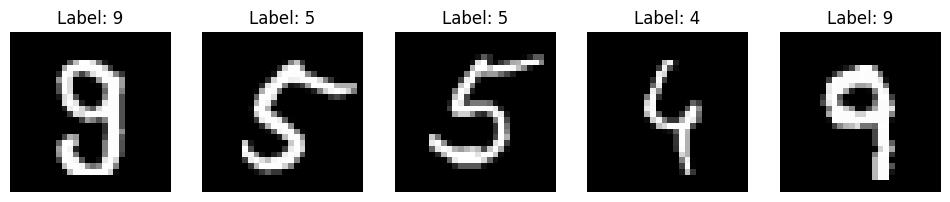


Examples from the Test Set:


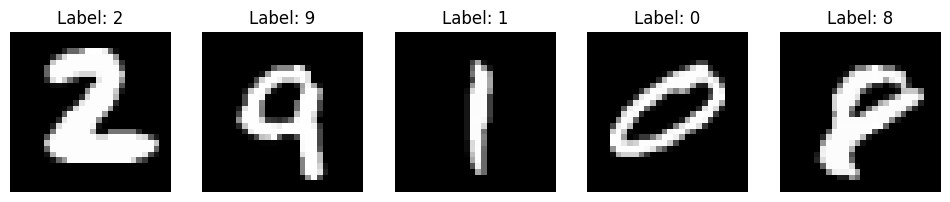

In [ ]:
# Define the MNIST datasets.
dataset_train_part = MNIST(
    os.getcwd(), download=True, transform=transforms.ToTensor(), train=True)
dataset_test_part = MNIST(
    os.getcwd(), download=True, transform=transforms.ToTensor(), train=False)


# Display examples from the training set
print("Examples from the Training Set:")
show_examples(dataset_train_part)

# Display examples from the test set
print("\nExamples from the Test Set:")
show_examples(dataset_test_part)

## Convolutional Neural Nets
A Convolutional Neural Network (CNN) is a specialized neural network designed for tasks involving structured grid data, particularly images. CNNs excel at capturing intricate features and patterns through their unique components:

1. **Convolutional Layers ($\text{Conv}$):** These layers employ a fundamental operation known as convolution to analyze input images. The convolutional operation involves sliding small learnable filters (also called kernels) across the input image, capturing local patterns at different spatial locations. Mathematically, the convolutional operation is expressed as:
   $$\text{Conv}(I, K) = I \ast K$$
   where $I$ is the input image, and $K$ is a learnable filter. The filters act as feature detectors, learning to recognize specific patterns, edges, or textures within the image (see `.gif` animation below for a visualization).

   The CNN learns these filters during the training process. Each filter specializes in detecting particular features, and through training, the network refines these filters to extract meaningful hierarchical representations from the input images.

2. **Activation Function ($\sigma(\cdot)$):** After each convolution operation, an activation function, typically ReLU ($$\sigma(x) = \max(0, x)$$), introduces non-linearity. This non-linearity is crucial for allowing the network to learn complex relationships and represent intricate features in the data.

3. **Pooling Layers ($\text{Pooling}$):** Following convolution, pooling layers reduce the spatial dimensions of the feature maps. Max pooling, for example, selects the maximum value from a group of neighboring pixels, aiding in retaining essential information while reducing computational load.

4. **Fully Connected Layers ($\text{FC}$):** The final layers of the CNN are fully connected, connecting neurons from the preceding layers to make decisions. These layers leverage the learned features to classify or regress on the input data.

In summary, the heart of a CNN lies in its convolutional layers, where learnable filters systematically analyze input images, capturing and refining intricate features that contribute to the network's ability to understand and interpret visual data.


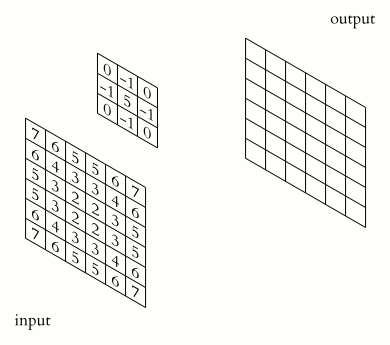

In [ ]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

class SimpleConvNet(nn.Module):
  '''
    Simple Convolutional Neural Network
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Conv2d(1, 10, kernel_size=3),
      nn.ReLU(),
      nn.Flatten(),
      nn.Linear(26 * 26 * 10, 50),
      nn.ReLU(),
      nn.Linear(50, 20),
      nn.ReLU(),
      nn.Linear(20, 10)
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

### [Reminder] Cross-entropy Loss

The cross-entropy loss, often used in classification problems, is a measure of the dissimilarity between the predicted probability distribution and the true probability distribution of the labels. Specifically, for a given instance, let $ y_i $ be the true label (a one-hot encoded vector) and $ \hat{y}_i $ be the predicted probability distribution over classes. The cross-entropy loss ($ H(y, \hat{y}) $) is defined as the negative log-likelihood of the correct labels:

$$ H(y, \hat{y}) = -\sum_{i} y_i \log(\hat{y}_i) $$

Here:
- $ y_i $ is the true probability distribution (a one-hot encoded vector representing the ground truth label).
- $ \hat{y}_i $ is the predicted probability distribution over classes generated by the model.
- $ \sum_i $ denotes the sum over all classes.

The negative log-likelihood term $ -\log(\hat{y}_i) $ penalizes the model more when it is confidently wrong about a prediction. If $ \hat{y}_i $ is close to $1$ (indicating high confidence) and $ y_i $ is $0$, the loss will be large (**why?**), encouraging the model to correct its prediction.

The overall loss $ H(y, \hat{y}) $ is the sum of these terms across all classes. Minimizing this loss during training helps the model to converge towards accurate predictions.



## K-fold Cross Validation

K-Fold Cross-Validation is a robust technique used to assess the performance and generalization of a machine learning model. It involves partitioning the dataset into k equally-sized folds and iteratively training and evaluating the model on different combinations of these folds. The key steps are as follows:

1. **Data Splitting:**
   - Divide the dataset into $k$ non-overlapping folds.
   - For each iteration, use $k-1$ folds for training and the remaining fold for testing.

2. **Model Training and Testing:**
   - Train the model on the $k-1$ training folds.
   - Evaluate the model on the held-out fold (testing set).

3. **Iteration:**
   - Repeat the process $k$ times, each time using a different fold as the testing set.
   - This ensures that each data point is used for testing exactly once.

4. **Performance Metrics:**
   - Record the performance metrics (e.g., accuracy, precision, recall) for each iteration.
   - Average the metrics across all iterations to obtain a more reliable estimate of the model's performance.

'Mathematically', the process can be represented as:
   $$\text{Fold}_{1} \rightarrow \text{Train}_{2,3,...,k} \quad \text{Test}_{1}$$
   $$\text{Fold}_{2} \rightarrow \text{Train}_{1,3,...,k} \quad \text{Test}_{2}$$
   $$\vdots$$
   $$\text{Fold}_{k} \rightarrow \text{Train}_{1,2,...,k-1} \quad \text{Test}_{k}$$

5. **Result Aggregation:**
   - Collect the performance metrics from each iteration.
   - Calculate the average and standard deviation of the metrics.

K-Fold Cross-Validation provides a more comprehensive evaluation of a model's robustness, reducing the impact of data variability and ensuring that the model's performance is consistent across different subsets of the data.


In [ ]:
def train_model(network, trainloader, optimizer, loss_function, num_epochs):
    # Function to perform the training.
    for epoch in range(num_epochs):
        print(f'Starting epoch {epoch + 1}')
        current_loss = 0.0

        for i, data in enumerate(trainloader, 0):
            inputs, targets = data
            optimizer.zero_grad()
            outputs = network(inputs)
            loss = loss_function(outputs, targets)
            loss.backward()
            optimizer.step()
            current_loss += loss.item()

            if i % 500 == 499:
                print(
                    'Loss after mini-batch %5d: %.3f' %
                     (i + 1, current_loss / 500)
                )
                current_loss = 0.0


def test_model(network, testloader):
   # Function to test the model on the test set for a fold
    correct, total = 0, 0

    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            inputs, targets = data
            outputs = network(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100.0 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    return accuracy


def k_fold_cross_validation(k_folds, num_epochs, loss_function):
    # Function to perform k-fold cross-validation
    results = {}
    dataset = ConcatDataset([dataset_train_part, dataset_test_part])
    kfold = KFold(n_splits=k_folds, shuffle=True)

    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
        print(f'FOLD {fold}')
        print('--------------------------------')

        train_subsampler = SubsetRandomSampler(train_ids)
        test_subsampler = SubsetRandomSampler(test_ids)

        trainloader = DataLoader(
            dataset, batch_size=10, sampler=train_subsampler)
        testloader = DataLoader(
            dataset, batch_size=10, sampler=test_subsampler)

        network = SimpleConvNet()
        network.apply(reset_weights)
        optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)

        train_model(network, trainloader, optimizer, loss_function, num_epochs)

        print('Training process has finished. Saving trained model.')
        print('Starting testing')

        save_path = f'./model-fold-{fold}.pth'
        torch.save(network.state_dict(), save_path)

        accuracy = test_model(network, testloader)
        results[fold] = accuracy
        print('--------------------------------')

    return results

# Function to print k-fold cross-validation results
def print_results(results):
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {len(results)} FOLDS')
    print('--------------------------------')

    total_accuracy = sum(results.values())
    average_accuracy = total_accuracy / len(results)

    for key, value in results.items():
        print(f'Fold {key}: {value:.2f}%')

    print(f'Average: {average_accuracy:.2f}%')

## Putting everything together

Call your `main` function and ensure that everything works.

In [ ]:
# Main function
def main():
    k_folds = 5
    num_epochs = 1
    loss_function = nn.CrossEntropyLoss()

    results = k_fold_cross_validation(k_folds, num_epochs, loss_function)
    print_results(results)

In [ ]:
main()

FOLD 0
--------------------------------
Reset trainable parameters of layer = Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = Linear(in_features=6760, out_features=50, bias=True)
Reset trainable parameters of layer = Linear(in_features=50, out_features=20, bias=True)
Reset trainable parameters of layer = Linear(in_features=20, out_features=10, bias=True)
Starting epoch 1
Loss after mini-batch   500: 1.819
Loss after mini-batch  1000: 0.816
Loss after mini-batch  1500: 0.533
Loss after mini-batch  2000: 0.425
Loss after mini-batch  2500: 0.389
Loss after mini-batch  3000: 0.370
Loss after mini-batch  3500: 0.339
Loss after mini-batch  4000: 0.308
Loss after mini-batch  4500: 0.309
Loss after mini-batch  5000: 0.304
Loss after mini-batch  5500: 0.297
Training process has finished. Saving trained model.
Starting testing
Accuracy: 91.46%
--------------------------------
FOLD 1
--------------------------------
Reset trainable parameters of layer = Conv